<a href="https://colab.research.google.com/github/YeimeLeandro/Hyperblog/blob/main/Flow_PRM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
import matplotlib.pyplot as plt

In [ ]:
# Cargar archivo NDVI
df = pd.read_excel(r"C:/Users\leand\OneDrive - PhD in Engineering\2. Class\4. Optimization\Informe_NDVI.xlsx")
df = df.dropna(subset=['longitud', 'latitud', 'NDVI']).reset_index(drop=True)

In [ ]:
# Variables: Longitud, Latitud y NDVI
features = df[['longitud', 'latitud', 'NDVI']].to_numpy()

In [ ]:
# Escalamiento para tener en cuenta el NDVI en igualdad de condiciones
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [ ]:
# Clustering con KMeans
kmeans_ndvi = KMeans(n_clusters=100, random_state=42).fit(scaled_features)
df['cluster_ndvi'] = kmeans_ndvi.labels_

In [ ]:
# Selección del punto más representativo por cluster
representantes_ndvi = []
for c in range(100):
    grupo = df[df['cluster_ndvi'] == c]
    centroide = kmeans_ndvi.cluster_centers_[c]
    idx_cercano = np.argmin(distance.cdist(scaler.transform(grupo[['longitud', 'latitud', 'NDVI']]), [centroide]))
    representantes_ndvi.append(grupo.iloc[idx_cercano])

df_reducido_ndvi = pd.DataFrame(representantes_ndvi).reset_index(drop=True)

c:\Users\leand\OneDrive - PhD in Engineering\2. Class\4. Optimization\treeprm_env\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\leand\OneDrive - PhD in Engineering\2. Class\4. Optimization\treeprm_env\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\leand\OneDrive - PhD in Engineering\2. Class\4. Optimization\treeprm_env\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\leand\OneDrive - PhD in Engineering\2. Class\4. Optimization\treeprm_env\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\leand\OneDrive - PhD in Engineering\2. Clas

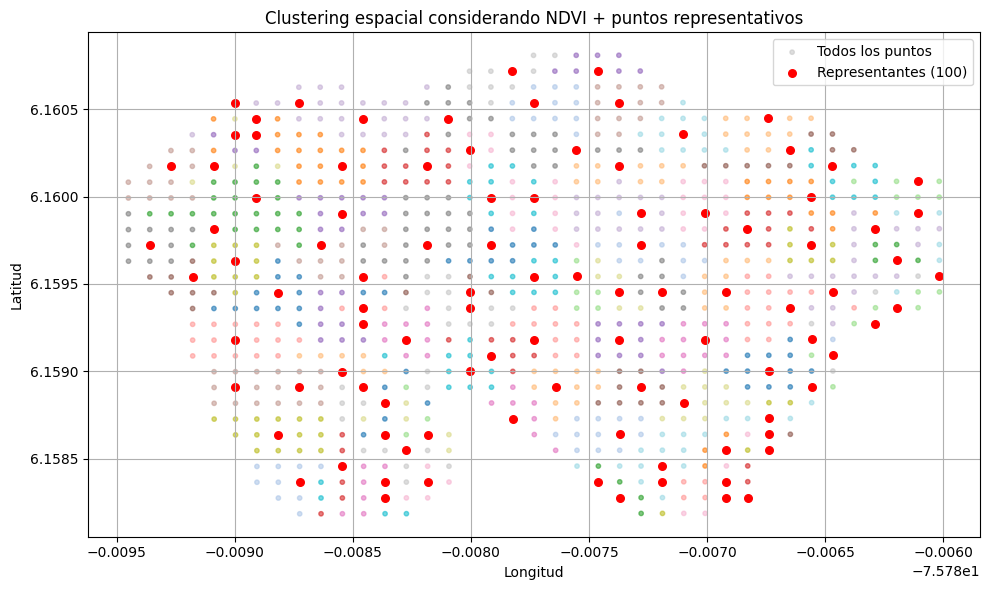

In [ ]:
# Visualización
plt.figure(figsize=(10, 6))
plt.scatter(df['longitud'], df['latitud'], c=df['cluster_ndvi'], cmap='tab20', s=10, alpha=0.6, label="Todos los puntos")
plt.scatter(df_reducido_ndvi['longitud'], df_reducido_ndvi['latitud'], color='red', s=30, label="Representantes (100)")
plt.title("Clustering espacial considerando NDVI + puntos representativos")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from gurobipy import Model, GRB, quicksum
from sklearn.neighbors import KDTree

In [ ]:
# Preparar datos
df = df_reducido_ndvi.copy()
points = df[['longitud', 'latitud']].to_numpy()
ndvi = df['NDVI'].to_numpy()
n = len(points)
p = 3

In [ ]:
# Matriz de disimilitud
d = {(i, j): abs(ndvi[i] - ndvi[j]) for i in range(n) for j in range(n)}

In [ ]:
# Vecindad
k = 20
tree = KDTree(points)
neighbors = {i: tree.query(points[i].reshape(1, -1), k+1)[1][0][1:].tolist() for i in range(n)}

In [ ]:
# Modelo
m = Model("Flow-PRM")
m.setParam("OutputFlag", 1)

Set parameter OutputFlag to value 1


In [ ]:
y = m.addVars(n, p, vtype=GRB.BINARY)
w = m.addVars(n, p, vtype=GRB.BINARY)
f = m.addVars(n, n, p, vtype=GRB.CONTINUOUS)
t = m.addVars(n, n, vtype=GRB.CONTINUOUS)

In [ ]:
# 1. Cada nodo pertenece a una sola región
for i in range(n):
    m.addConstr(quicksum(y[i, k_] for k_ in range(p)) == 1)

# 2. Un solo centro por región
for k_ in range(p):
    m.addConstr(quicksum(w[i, k_] for i in range(n)) == 1)

# 3. Un nodo solo puede ser centro si pertenece a la región
for i in range(n):
    for k_ in range(p):
        m.addConstr(w[i, k_] <= y[i, k_])

# 4. Flujo entre nodos solo si ambos están en la misma región
for i in range(n):
    for j in neighbors[i]:
        for k_ in range(p):
            m.addConstr(f[i, j, k_] <= (n - p) * y[i, k_], name=f"flujo_yik_{i}_{j}_{k_}")
            m.addConstr(f[i, j, k_] <= (n - p) * y[j, k_], name=f"flujo_yjk_{i}_{j}_{k_}")

# 5. Conservación de flujo (contigüidad espacial)
for i in range(n):
    for k_ in range(p):
        inflow = quicksum(f[j, i, k_] for j in neighbors[i] if (j, i, k_) in f)
        outflow = quicksum(f[i, j, k_] for j in neighbors[i] if (i, j, k_) in f)
        m.addConstr(outflow - inflow >= y[i, k_] - (n - p) * w[i, k_], name=f"conservacion_flujo_{i}_{k_}")


In [ ]:
# Objetivo
m.setObjective(quicksum(d[i, j] * t[i, j] for i in range(n) for j in neighbors[i]), GRB.MINIMIZE)

# Optimizar
m.optimize()

# Validar si el modelo fue resuelto óptimamente
if m.Status == GRB.OPTIMAL:
    asignaciones = [k_ for i in range(n) for k_ in range(p) if y[i, k_].X > 0.5]
    df['region'] = asignaciones
else:
    print(f"No se encontró solución óptima. Estado: {m.Status}")

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 12703 rows, 40600 columns and 37800 nonzeros
Model fingerprint: 0x58a60d2d
Variable types: 40000 continuous, 600 integer (600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [5e-05, 6e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


In [ ]:
regiones = []
for i in range(n):
    for k_ in range(p):
        if y[i, k_].X > 0.5:
            regiones.append(k_)
            break

df_reducido_ndvi['region'] = regiones



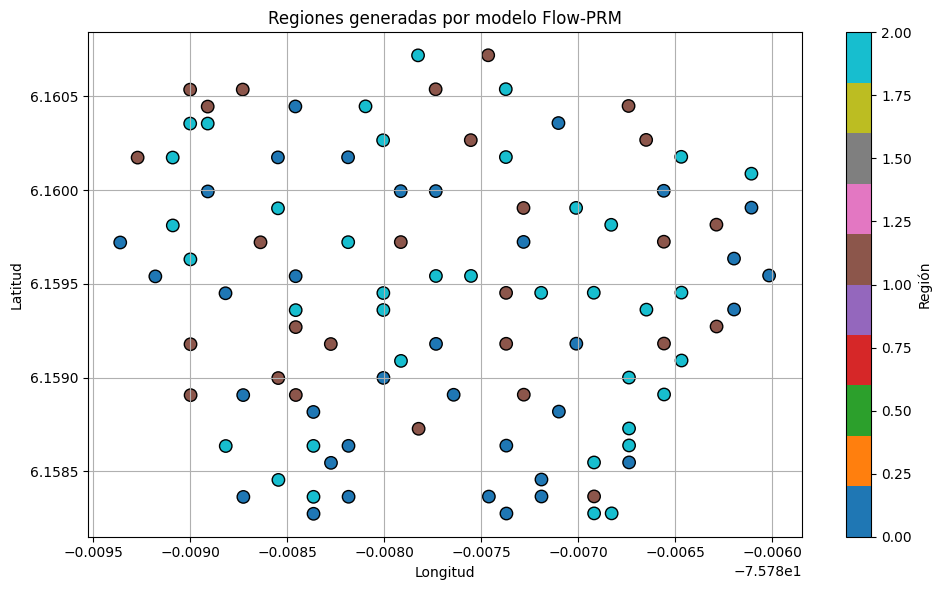

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_reducido_ndvi['longitud'], df_reducido_ndvi['latitud'],
    c=df_reducido_ndvi['region'], cmap='tab10', s=80, edgecolor='black'
)
plt.title("Regiones generadas por modelo Flow-PRM")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.grid(True)
plt.colorbar(scatter, label='Región')
plt.tight_layout()
plt.show()


In [ ]:
df_reducido_ndvi['region'] = regiones


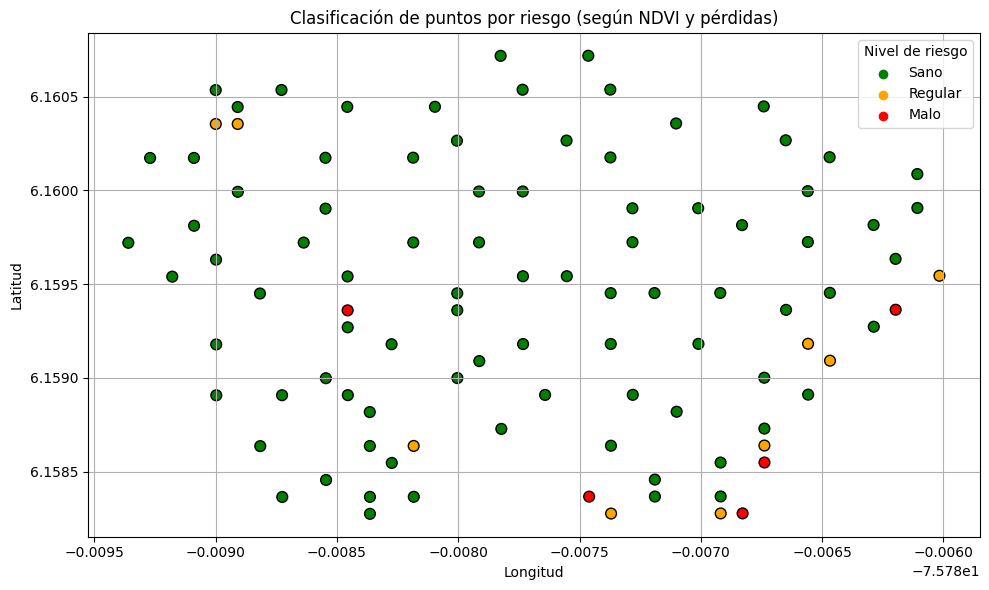

In [ ]:
import matplotlib.pyplot as plt

# Clasificar NDVI según el artículo (Expected, Unexpected, Stress Losses)
def clasificar_ndvi_riesgo(ndvi):
    if ndvi > 0.6:
        return "Sano"
    elif 0.4 <= ndvi <= 0.6:
        return "Regular"
    else:
        return "Malo"

# Crear columna con la clasificación
df_reducido_ndvi['clasificacion_riesgo'] = df_reducido_ndvi['NDVI'].apply(clasificar_ndvi_riesgo)

# Definir colores
color_dict = {'Sano': 'green', 'Regular': 'orange', 'Malo': 'red'}
colors = df_reducido_ndvi['clasificacion_riesgo'].map(color_dict)

# Graficar los puntos
plt.figure(figsize=(10, 6))
plt.scatter(
    df_reducido_ndvi['longitud'],
    df_reducido_ndvi['latitud'],
    c=colors,
    s=60,
    edgecolors='black'
)

# Agregar leyenda manual
for label in color_dict:
    plt.scatter([], [], color=color_dict[label], label=label)

plt.title("Clasificación de puntos por riesgo (según NDVI y pérdidas)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.grid(True)
plt.legend(title="Nivel de riesgo")
plt.tight_layout()
plt.show()


C:\Users\leand\AppData\Local\Temp\ipykernel_8800\558397287.py:28: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  plt.scatter(


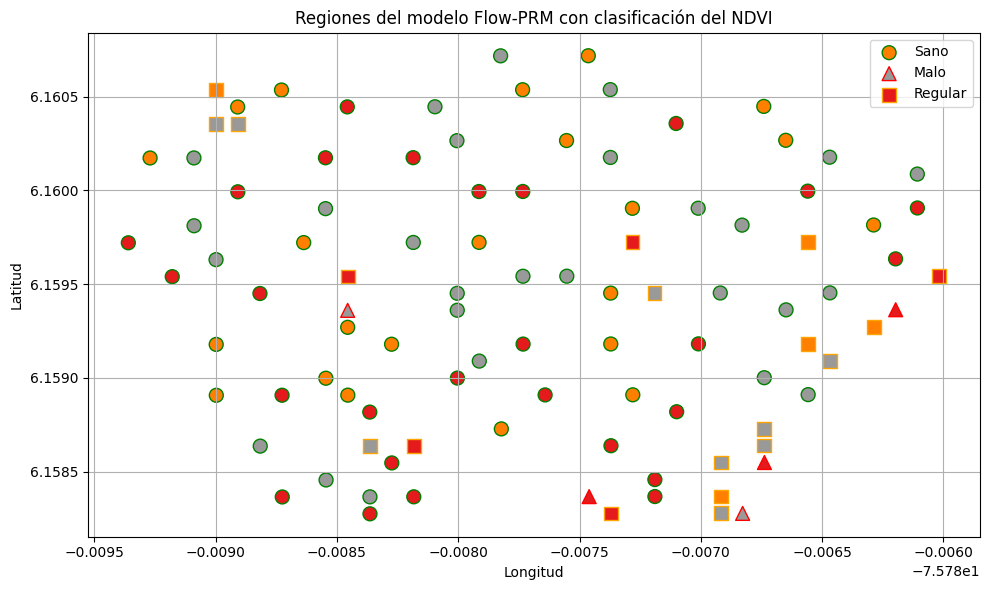

In [ ]:
import matplotlib.pyplot as plt

# Clasificación del NDVI
def clasificar_ndvi(ndvi):
    if ndvi >= 0.7:
        return "Sano"
    elif ndvi >= 0.4:
        return "Regular"
    else:
        return "Malo"

# Aplicar la clasificación
df_reducido_ndvi['clasificación'] = df_reducido_ndvi['NDVI'].apply(clasificar_ndvi)

# Asignar estilo de marcador según clasificación
estilos = {
    "Sano": {'marker': 'o', 'facecolors': 'none', 'edgecolors': 'green', 'label': 'Sano'},
    "Regular": {'marker': 's', 'facecolors': 'none', 'edgecolors': 'orange', 'label': 'Regular'},
    "Malo": {'marker': '^', 'facecolors': 'none', 'edgecolors': 'red', 'label': 'Malo'}
}

# Crear figura
plt.figure(figsize=(10, 6))

# Plotear cada punto con estilo y color por región
for clasificacion in df_reducido_ndvi['clasificación'].unique():
    datos = df_reducido_ndvi[df_reducido_ndvi['clasificación'] == clasificacion]
    plt.scatter(
        datos['longitud'],
        datos['latitud'],
        c=datos['region'],
        cmap='Set1',
        s=100,
        **estilos[clasificacion]
    )

plt.title("Regiones del modelo Flow-PRM con clasificación del NDVI")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
